In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
movies = pd.read_csv('data/IMDbMovies.csv')
movies.columns

Index(['movie title', 'Run Time', 'Rating', 'User Rating', 'Genres',
       'Overview', 'Plot Keyword', 'Director', 'Top 5 Casts', 'Writer', 'year',
       'path'],
      dtype='object')

In [3]:
def txt_to_int(txt):
    end = txt[-1]
    if end.isdigit():
        return int(txt)

    factor = 1
    if end == 'M':
        factor = 1e6
    elif end == 'K':
        factor = 1e3

    return int(factor * float(txt[:-1]))

def to_float(txt):
    try:
        return float(txt)
    except:
        return np.nan
    
def to_date(txt):
    try:
        return txt[1:]
    except:
        return txt

def preprocess(data : pd.DataFrame, dropna=True):
    df = pd.DataFrame()
    df['title'] = data['movie title']
    df['votes'] = data['User Rating'].apply(txt_to_int)
    df['rating'] = data['Rating'].apply(to_float) * np.log(df['votes'])

    df['writer'] = data['Writer']
    df['director'] = data['Director']

    to_expression = lambda x: eval(x)
    df['actors'] = data['Top 5 Casts'].apply(to_expression)
    df['genres'] = data['Genres'].apply(to_expression)
    df['plotwords'] = data['Plot Keyword'].apply(to_expression)
    df['year'] = data['year'].apply(to_date)

    if dropna:
        # NaN occurs when not enough people have watched the film
        # OR
        # enough data wasn't collected
        df.dropna(inplace=True)

    df.sort_values('rating', ascending=False, inplace=True)
    df.drop_duplicates(subset='title', keep='first', inplace=True)

    return df


### Adjusted Rating is calculated by $s\log_{10}{(v)}$
where

${s =}$ Average IMDb Score

${v =}$ Number of Votes

/home/javkt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


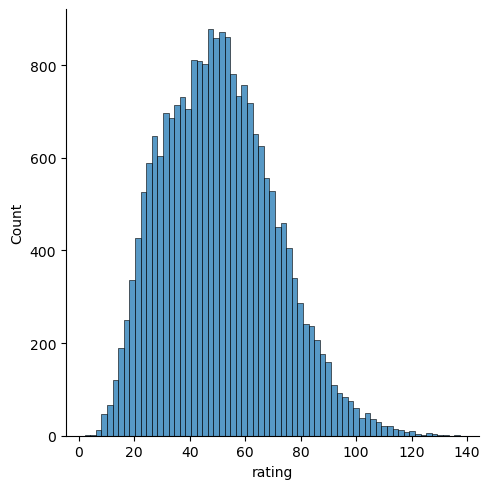

,title,votes,rating,writer,director,actors,genres,plotwords,year
8021,The Shawshank Redemption,2600000,137.370505,Stephen King,Frank Darabont,"[Frank Darabont, Tim Robbins, Morgan Freeman, ...",[Drama],"[wrongful imprisonment, prison, based on the w...",1994
51,The Dark Knight,2600000,132.939198,Jonathan Nolan,Christopher Nolan,"[Christopher Nolan, David S. Goyer, Christian ...","[Action, Crime, Drama]","[dc comics, moral dilemma, psychopath, clown, ...",2008
7999,The Godfather,1800000,132.510334,Mario Puzo,Francis Ford Coppola,"[Francis Ford Coppola, Marlon Brando, Al Pacin...","[Crime, Drama]","[mafia, patriarch, crime family, organized cri...",1972
146,The Lord of the Rings: The Return of the King,1800000,129.629675,J.R.R. Tolkien,Peter Jackson,"[Fran Walsh, Philippa Boyens, Elijah Wood, Vig...","[Action, Adventure, Drama]","[epic, orc, hobbit, ring, middle earth, battle...",2003
8042,Pulp Fiction,2000000,129.127054,Quentin Tarantino,Quentin Tarantino,"[Roger Avary, John Travolta, Uma Thurman, Samu...","[Crime, Drama]","[nonlinear timeline, overdose, drug use, drug ...",1994


In [4]:
df = preprocess(movies)
sns.displot(df.rating)
plt.show()
df.head()

In [5]:
def get_people(column, min_appearances=3, log_base=5):
    people = {}
    for i, person in enumerate(df[column]):
        if type(person) != str:
            for p in person:
                if p not in people:
                    people[p] = [df['rating'].iloc[i]]
                else:
                    people[p].append(df['rating'].iloc[i])
        else:
            if person not in people:
                people[person] = [df['rating'].iloc[i]]
            else:
                people[person].append(df['rating'].iloc[i])
    
    people_df = pd.DataFrame(columns=['rating', 'appearances', 'likeability'])
    people_df['name'] = people.keys()
    people_df.index = people_df['name']
    people_df.drop('name', axis=1, inplace=True)
    
    for person in people:
        len_ = len(people[person])
        if len_ < min_appearances:
            continue

        max_ = max(people[person])
        mean_ = np.mean(people[person])
        upper_bound = (mean_ + np.std(people[person], ddof=1))/max_

        people_df.loc[person] = [max_, len_, max_*upper_bound*math.log(len_, log_base)]
        
    people_df.sort_values('likeability', ascending=False, inplace=True)
    people_df.dropna(inplace=True)
    return people_df


In [6]:
get_people('actors').to_csv('data/actors.csv', index=False)
get_people('director').to_csv('data/directors.csv', index=False)
get_people('writer').to_csv('data/writers.csv', index=False)
df.to_csv('data/movies.csv', index=False)

In [7]:
genre_list = []
for generes in df['genres']:
    for genre in generes:
        if genre not in genre_list:
            genre_list.append(genre)
genre_list


['Drama',
 'Action',
 'Crime',
 'Adventure',
 'Sci-Fi',
 'Romance',
 'Biography',
 'History',
 'Mystery',
 'Thriller',
 'War',
 'Fantasy',
 'Western',
 'Comedy',
 'Animation',
 'Family',
 'Horror',
 'Music',
 'Sport',
 'Film-Noir',
 'Musical',
 'Reality-TV',
 'Adult',
 'Game-Show']